# Load VGG model

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.trainer as trainer
import torch.utils.trainer.plugins
from torch.autograd import Variable
import numpy as np
import os

In [2]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [3]:
data_path = "data/dogscats/"
# data_path = "data/dogscats/sample/"

In [4]:
use_cuda = torch.cuda.is_available()
print('Using CUDA:', use_cuda)

Using CUDA: True


In [5]:
# Data loading code
traindir = os.path.join(data_path, 'train')
valdir = os.path.join(data_path, 'valid')
batch_size = 64

# pytorch way of implementing fastai's get_batches, (utils.py)
def get_data_loader(dirname, shuffle=True, batch_size = 64):
    # pytorch's VGG requires images to be 224x224 and normalized using https://github.com/pytorch/vision#models
    normalize = transforms.Compose([
        transforms.Lambda(lambda img: img.resize((224, 224), Image.BILINEAR)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image_folder = datasets.ImageFolder(dirname, normalize)
    return torch.utils.data.DataLoader(image_folder, batch_size=batch_size, shuffle=shuffle, pin_memory=use_cuda)

train_loader = get_data_loader(traindir, batch_size=batch_size)
val_loader = get_data_loader(valdir, shuffle=False, batch_size=batch_size)

In [6]:
# Load the model
model = models.vgg16(pretrained=True)

In [7]:
# Finetune by replacing the last fully connected layer and freezing all network parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully-connected layer matching the new class count
classes = train_loader.dataset.classes
num_classes = len(classes)
print('Using {:d} classes: {}'.format(num_classes, classes))
model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

Using 2 classes: ['cats', 'dogs']


In [8]:
# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
# enable cuda if available
if(use_cuda):
    model.cuda()
    criterion.cuda()
optimizer = optim.SGD(model.classifier.parameters(), lr=1e-2, momentum=0.9)

In [9]:
# fine-tune with new classes
t = trainer.Trainer(model, criterion, optimizer, train_loader)
t.register_plugin(trainer.plugins.ProgressMonitor())
t.register_plugin(trainer.plugins.AccuracyMonitor())
t.register_plugin(trainer.plugins.LossMonitor())
t.register_plugin(trainer.plugins.TimeMonitor())
t.register_plugin(trainer.plugins.Logger(['progress', 'accuracy', 'loss', 'time']))

# Requires a monkey patched version of trainery.py that calls
# input_var = Variable(batch_input.cuda())    # Line 57
# target_var = Variable(batch_target.cuda())  # Line 58
epochs = 1
t.run(epochs)

progress: 64/360 (17.78%)	accuracy: 56.25%  (16.88%)	loss: 0.7257  (0.2177)	time: 0ms  (0ms)
progress: 128/360 (35.56%)	accuracy: 64.06%  (31.03%)	loss: 0.6079  (0.3348)	time: 9436ms  (2831ms)
progress: 192/360 (53.33%)	accuracy: 90.62%  (48.91%)	loss: 0.4234  (0.3614)	time: 9185ms  (4737ms)
progress: 256/360 (71.11%)	accuracy: 92.19%  (61.89%)	loss: 0.2963  (0.3418)	time: 9704ms  (6227ms)
progress: 320/360 (88.89%)	accuracy: 96.88%  (72.39%)	loss: 0.1921  (0.2969)	time: 7405ms  (6580ms)
progress: 384/360 (106.67%)	accuracy: 96.88%  (79.73%)	loss: 0.1835  (0.2629)	time: 10122ms  (7643ms)
progress: 448/360 (124.44%)	accuracy: 92.19%  (83.47%)	loss: 0.2101  (0.2470)	time: 10298ms  (8440ms)
progress: 512/360 (142.22%)	accuracy: 98.44%  (87.96%)	loss: 0.0517  (0.1884)	time: 6727ms   (7926ms)
progress: 576/360 (160.00%)	accuracy: 98.44%  (91.10%)	loss: 0.0649  (0.1514)	time: 8442ms   (8081ms)
progress: 640/360 (177.78%)	accuracy: 98.44%  (93.30%)	loss: 0.0370  (0.1171)	time: 5995ms   (7455m

In [10]:
# Define some helper functions

def denorm(tensor):
    # Undo the image normalization + clamp between 0 and 1 to avoid image artifacts
    for t, m, s in zip(tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): 
        t.mul_(s).add_(m).clamp_(0, 1)
    return tensor

def get_images_to_plot(images_tensor):
    denormalize = transforms.Compose([
        transforms.Lambda(denorm)
    ])
    return denormalize(images_tensor)

def get_classes_strings(classes, labels_ids):
    # returns the classes in string format
    return [classes[label_id] for label_id in labels_ids]

def get_prediction_classes_ids(predictions):
    # returns the predictions in id format
    predictions_ids = predictions.cpu().data.numpy().argmax(1)
    return predictions_ids

def get_prediction_classes_strings(classes, predictions):
    # returns the predictions in string format
    return get_classes_strings(classes, get_prediction_classes_ids(predictions))

['cats', 'cats', 'dogs', 'dogs']


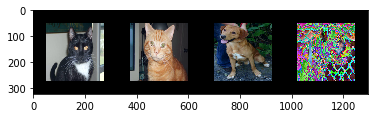

In [11]:
# display a sample set of images and their labels
train_loader = get_data_loader(valdir, batch_size = 4)
images, labels = next(iter(train_loader))
show(make_grid(get_images_to_plot(images), padding=100))
labels_string = get_classes_strings(classes, labels.numpy())
print(labels_string)

In [12]:
# display the predictons for the images above
if use_cuda:
    images = images.cuda()
predictions = model(Variable(images))
predictions_string = get_prediction_classes_strings(classes, predictions)
print(predictions_string)

['cats', 'cats', 'dogs', 'dogs']


In [13]:
import sys

def get_accuracy(val_loader):
    # Process each mini-batch and accumulate all correct classifications
    correct = 0
    num_batches = sum(1 for b in enumerate(val_loader))
    batches = enumerate(val_loader)
    for i, (images, labels) in batches:
        sys.stdout.write('\rBatch: {:d}/{:d}'.format(i + 1, num_batches))
        sys.stdout.flush()
        if use_cuda:
            images = images.cuda()
        predictions = model(Variable(images))
        prediction_classes_ids = torch.from_numpy(get_prediction_classes_ids(predictions))
        correct += labels.eq(prediction_classes_ids).sum()
    # Avoid carriage return
    print('')
    return 100.0 * correct / len(val_loader.dataset.imgs)

In [14]:
print('Accuracy for validation set: {}'.format(get_accuracy(val_loader)))

Batch: 32/32
Accuracy for validation set: 98.6
